## 1. 인공신경망 학습 코드 (Neural Network Training Code)

### 기본 설정 (Basic Setup)

In [ ]:
# 사용될 라이브러리를 설치하는 코드입니다.
# 라이브러리는 똑똑한 사람들이 미리 만들어준 코드라고 생각하시면 됩니다.
# 이 코드는 처음 한 번만 실행하면 됩니다.
# 만약에 라이브러리가 추가되면 requirements.txt 파일에 추가하고 이 코드를 다시 실행하면 됩니다.
# requirements.txt는 라이브러리 이름과 버전을 적어놓은 파일입니다!
!pip install -r requirements.txt

In [2]:
# 라이브러리를 가져옵니다.
# "import 라이브러리명 as 별명" 으로 가져올 수 있습니다.
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# 재현성을 위한 시드 설정
# 시드란 무작위 숫자를 생성할 때 사용하는 기준값입니다.
# 시드를 설정하면 같은 시드일 때 같은 숫자가 나오도록 만들 수 있습니다.
torch.manual_seed(42)
np.random.seed(42)

# GPU 사용 가능 여부 확인
# GPU를 사용하면 연산 속도가 빨라집니다.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"사용 중인 디바이스 (Using device): {device}")

사용 중인 디바이스 (Using device): cpu


### 토이 데이터셋 생성 (Create Toy Dataset)

먼저 딥러닝이 어떻게 진행되는지 배우기 전에,
2 클래스 분류 문제를 위한 토이 데이터 생성을 먼저 해봅시다.

2 클래스 분류 문제란 두 개의 "클래스"
즉, 두 개의 그룹이 있을 때, 새로운 데이터가 들어오게 되면,
이 데이터가 어느 그룹에 속하는지 분류하는 문제입니다.

### np.random.randn()

**정의**: 평균이 0이고 표준편차가 1인 가우시안 분포(정규 분포)에서 단일 난수를 생성해주는 함수입니다.

**배열 생성**: 이 함수의 인자에 `np.random.randn(3, 4)`처럼 숫자를 적어주면, 해당 형태의 배열로 난수를 생성해줍니다.

### 예시 코드

```python
import numpy as np

# 난수 생성기 시드 설정 (재현성을 위해)
np.random.seed(42)

# 1차원 배열 (5개 요소)
array_1d = np.random.randn(5)
print("1차원 배열:")
print(array_1d)

# 2차원 배열 (3x4)
array_2d = np.random.randn(3, 4)
print("\n2차원 배열:")
print(array_2d)

# 3차원 배열 (2x3x2)
array_3d = np.random.randn(2, 3, 2)
print("\n3차원 배열:")
print(array_3d)
```

### 실행 결과

**1차원 배열:**
```
[ 0.49671415 -0.1382643   0.64768854  1.52302986 -0.23415337]
```

**2차원 배열**
```
[[-0.23413696  1.57921282  0.76743473 -0.46947439]
 [ 0.54256004 -0.46341769 -0.46572975  0.24196227]
 [-1.91328024 -1.72491783 -0.56228753 -1.01283112]]
```

**3차원 배열**
```
[[[ 0.31424733 -0.90802408]
  [-1.4123037   1.46564877]
  [-0.2257763   0.0675282 ]]

 [[-1.42474819 -0.54438272]
  [ 0.11092259 -1.15099358]
  [ 0.37569802 -0.60063869]]]
```

In [4]:
def generate_toy_data(n_samples=1000):
    # 2 클래스 이므로 각 클래스 당 샘플 수를 구해줍시다.
    n_samples_per_class = n_samples // 2
    
    # 클래스 0의 데이터를 생성해줍니다. np.random.randn으로 랜덤한 숫자를 생성하고,
    # 이를  * 0.5 + np.array([2, 2]) 로 (2, 2)를 중심으로 만들어줍니다.
    X0 = np.random.randn(n_samples_per_class, 2) * 0.5 + np.array([2, 2])
    # 클래스 0의 데이터는 0으로 레이블링해줍니다.
    # 이 레이블은 이후에 모델이 학습할 때 사용됩니다.
    y0 = np.zeros(n_samples_per_class)
    
    # 클래스 1 데이터도 같은 방식으로 생성해줍니다. (-2, -2)를 중심으로 하기 때문에 이 데이터는 클래스 0과 다른 패턴을 가집니다.
    X1 = np.random.randn(n_samples_per_class, 2) * 0.5 + np.array([-2, -2])
    # 클래스 1의 데이터는 1로 레이블링해줍니다.
    y1 = np.ones(n_samples_per_class)
    
    # 데이터를 합쳐줍시다.
    # np.vstack은 수직으로 데이터를 합쳐주는 함수입니다.
    X = np.vstack([X0, X1])
    # np.hstack은 수평으로 데이터를 합쳐주는 함수입니다.
    y = np.hstack([y0, y1])
    
    # 데이터를 섞어줍시다.
    # np.random.permutation은 데이터를 섞어주는 함수입니다.
    # 예를 들어, np.random.permutation(10)을 하면 [3, 1, 4, 0, 7, 6, 2, 9, 8, 5] 이런 식으로 반환됩니다.
    indices = np.random.permutation(n_samples)
    # 섞인 인덱스를 통해서 데이터를 섞어줍니다.
    # 예를 들어, X[indices]는 X의 데이터를 섞어준 데이터를 반환합니다.
    # y도 마찬가지로 섞어줍니다.
    X, y = X[indices], y[indices]
    
    return X, y

# 위에 만들어둔 함수를 통해서 데이터를 생성해줍시다.
X, y = generate_toy_data(1000)

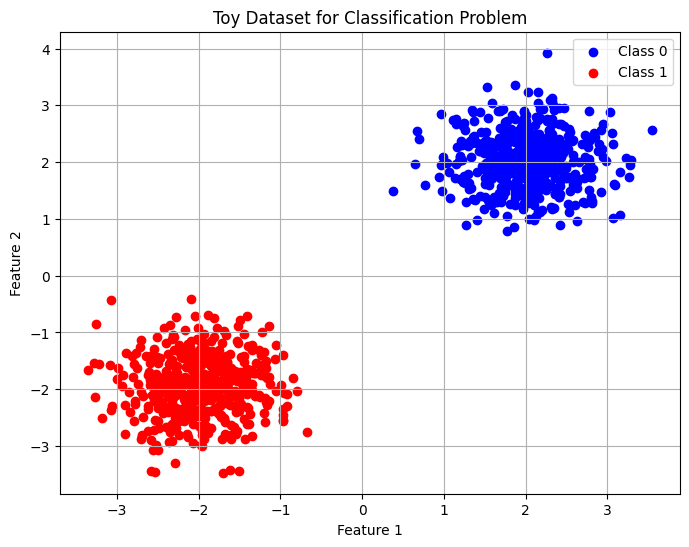

In [5]:
# 데이터 시각화
# matplotlib을 통해서 데이터를 시각화할 수 있습니다.
# plt.scatter은 산점도를 그려주는 함수입니다.
# 산점도는 데이터의 분포를 보여줍니다.
plt.figure(figsize=(8, 6))
plt.scatter(X[y==0, 0], X[y==0, 1], color='blue', label='Class 0')
plt.scatter(X[y==1, 0], X[y==1, 1], color='red', label='Class 1')
plt.title('Toy Dataset for Classification Problem')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True)
plt.show()

In [6]:
# 데이터를 학습 데이터와 테스트 데이터로 나눠줍니다.
# 학습 데이터는 모델을 학습시킬 때 사용하고, 테스트 데이터는 모델을 평가할 때 사용합니다.
# 일반적으로 학습 데이터는 80%, 테스트 데이터는 20%로 나눠줍니다.
# 데이터의 학습은 아까 라벨링한 데이터를 통해 이루어집니다.
train_ratio = 0.8
train_size = int(len(X) * train_ratio)

X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

# PyTorch 텐서로 변환
# PyTorch는 데이터를 텐서로 변환해서 사용합니다.
# 텐서는 다차원 배열입니다.
X_train_tensor = torch.FloatTensor(X_train).to(device)
y_train_tensor = torch.FloatTensor(y_train).to(device)
X_test_tensor = torch.FloatTensor(X_test).to(device)
y_test_tensor = torch.FloatTensor(y_test).to(device)

print(f"학습 데이터 크기 (Training data size): {X_train_tensor.shape}")
print(f"테스트 데이터 크기 (Test data size): {X_test_tensor.shape}")

학습 데이터 크기 (Training data size): torch.Size([800, 2])
테스트 데이터 크기 (Test data size): torch.Size([200, 2])


### 신경망 모델 정의 (Define Neural Network Model)

### 1. 신경망이란 무엇인가요?

신경망은 우리 뇌의 신경세포(뉴런)에서 영감을 받은 컴퓨터 알고리즘입니다.   
마치 우리 뇌가 여러 뉴런들이 연결되어 정보를 처리하듯, 인공 신경망도 여러 '인공 뉴런'들이 연결되어 데이터를 처리합니다.   
순전파와 역전파를 통해서 실제 데이터를 분류하는 등 다양한 task를 숫자로 풀 수 있게 해줍니다.

### 2. SimpleNN 모델 구조

코드에 나온 모델은 3개의 층(레이어)으로 구성된 간단한 '피드포워드' 신경망입니다.   

$입력층 \rightarrow 은닉층1 \rightarrow 은닉층2 \rightarrow 출력층$

- **입력층**: 데이터가 처음 들어오는 곳
- **은닉층**: 데이터를 처리하는 중간 층들
- **출력층**: 최종 예측 결과를 내보내는 층

### 3. 수학적 표현

각 층에서 일어나는 계산을 수식으로 표현하면:

1. 첫 번째 층: $h_1 = ReLU(W_1 \cdot x + b_1)$
2. 두 번째 층: $h_2 = ReLU(W_2 \cdot h_1 + b_2)$
3. 출력 층: $y = Sigmoid(W_3 \cdot h_2 + b_3)$

여기서,
- $x$는 입력 데이터
- $W$는 가중치(weight)
- $b$는 편향(bias)
- $ReLU(z) = max(0, z)$ (음수는 0으로, 양수는 그대로)
- $Sigmoid(z) = \frac{1}{1 + e^{-z}}$ (값을 0~1 사이로 변환)

### 4. 순전파(Forward Propagation)란?

순전파는 데이터가 입력층부터 출력층까지 차례대로 흘러가는 과정입니다. 코드의 `forward()` 함수가 바로 이 역할을 합니다.

1. 입력 데이터 $x$를 받습니다.
2. 첫 번째 층에서 계산: $x$에 가중치를 곱하고 편향을 더한 후 ReLU 활성화 함수 적용
3. 두 번째 층에서 계산: 위 결과에 다시 가중치를 곱하고 편향을 더한 후 ReLU 적용
4. 출력 층에서 계산: 위 결과에 가중치를 곱하고 편향을 더한 후 시그모이드 함수 적용
5. 최종 예측값(0~1 사이)을 출력

### 5. 역전파(Backward Propagation)란?

역전파는 모델의 예측과 실제 정답 사이의 오차를 계산한 후, 이 오차를 역방향으로 전파하면서 각 가중치와 편향을 조정하는 과정입니다.
이 때 이 가중치와 편향이 조정되는 과정을 "학습"이라고 하며, 조정된 값들이 해결할 task를 해결할 수 있게 해줍니다.

1. 손실 함수를 통해 예측값과 실제값의 차이(오차) 계산
2. 이 오차가 각 파라미터(가중치, 편향)에 미치는 영향(기울기)을 계산
3. 기울기를 이용해 파라미터 업데이트

수식으로는: $W_{new} = W_{old} - \alpha \cdot \frac{\partial Loss}{\partial W}$

여기서 $\alpha$는 학습률(learning rate)로, 업데이트 강도를 조절합니다.

### 6. 모델이 라벨을 어떻게 학습하나요?

1. **데이터와 라벨 준비**: 입력 데이터($x$)와 정답 라벨($y_{true}$)이 준비되어 있어야합니다.
2. **순전파**: 모델에 입력 데이터를 넣어 예측값($y_{pred}$)을 얻습니다.
3. **손실 계산**: 예측값과 실제 라벨 사이의 차이를 손실 함수(주로 이진 교차 엔트로피)로 계산합니다.
   $Loss = -[y_{true} \log(y_{pred}) + (1-y_{true}) \log(1-y_{pred})]$
4. **역전파**: 손실을 역방향으로 전파하며 각 파라미터의 기울기를 계산합니다.
5. **파라미터 업데이트**: 기울기를 이용해 가중치와 편향을 조정합니다.
6. **반복**: 1~5 과정을 여러 번 반복하면서 점점 더 정확한 예측을 하도록 학습합니다.

### 7. 왜 활성화 함수를 사용하나요?

- **ReLU 활성화 함수**: 비선형성을 추가하여 복잡한 관계를 학습할 수 있게 해줍니다. 또한, 기울기 소실 문제를 완화할 수 있습니다.
- **시그모이드 출력 함수**: 출력값을 0~1 사이로 변환하여 이진 분류(예: 합격/불합격, 정상/비정상)에 적합하게끔 숫자를 바꿔줍니다. (0.5 이상이면 ~ 이하면 ~)

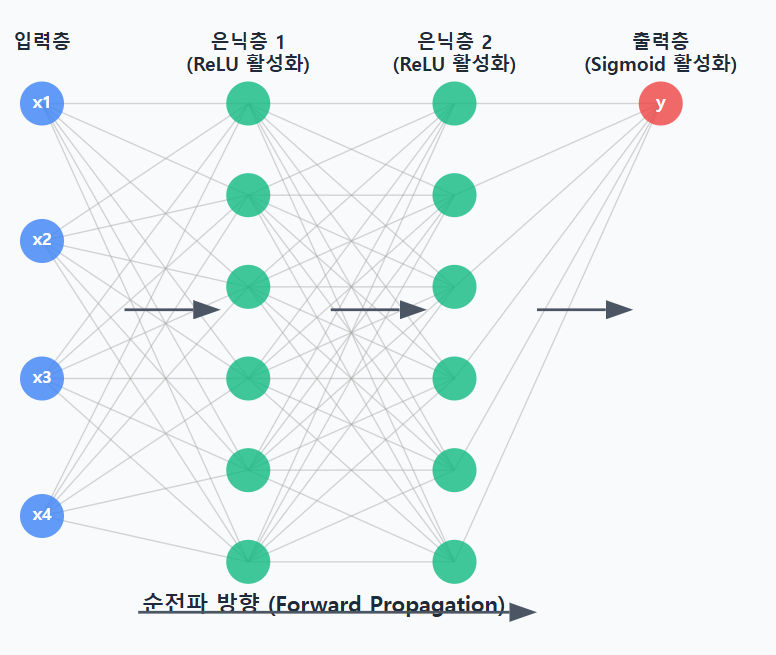

In [7]:
class SimpleNN(nn.Module):
    """
    간단한 피드포워드 신경망(Simple feedforward neural network)을 구현해 봅시다.
    """
    def __init__(self, input_size, hidden_size, output_size):
        """
        모델 구조 초기화 (Initialize model architecture)
        """
        super(SimpleNN, self).__init__()
        
        # 레이어 정의 (Define layers)
        # nn.Linear는 선형 변환을 수행하는 레이어입니다.
        # nn.ReLU는 활성화 함수로 ReLU를 사용합니다.
        # nn.Sigmoid는 활성화 함수로 시그모이드를 사용합니다.
        # 아래에서 예시를 통해 어떻게 변형되는지 확인해봅시다.
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.activation1 = nn.ReLU()
        self.layer2 = nn.Linear(hidden_size, hidden_size)
        self.activation2 = nn.ReLU()
        self.layer3 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid() # 이진 분류 문제이므로 시그모이드 사용
        
    def forward(self, x):
        """
        순전파(Forward pass, 역전파는 자동계산, backward() 호출로 수행)
        """
        x = self.layer1(x)
        x = self.activation1(x)
        x = self.layer2(x)
        x = self.activation2(x)
        x = self.layer3(x)
        x = self.sigmoid(x)
        return x

### 예시 데이터로 보는 신경망 변환 과정

간단한 예제 데이터를 통해 신경망에서 일어나는 변환 과정을 단계별로 설명해 드리겠습니다. 이해를 돕기 위해 작은 크기의 신경망과 구체적인 숫자를 사용하겠습니다.

**예시 설정**

* 입력 크기(input_size): 3
* 은닉층 크기(hidden_size): 4
* 출력 크기(output_size): 1

**가중치와 편향 값 (학습 후)**

실제로는 학습을 통해 결정되지만, 설명을 위해 다음과 같은 값들이 학습되었다고 가정합니다:

**레이어 1 (입력층 → 은닉층1)**
```
가중치(W1):
[[ 0.1,  0.2,  0.3],
 [-0.1,  0.1, -0.2],
 [ 0.3, -0.3,  0.2],
 [ 0.2,  0.2, -0.1]]

편향(b1): [0.1, -0.1, 0.1, 0.2]
```

**레이어 2 (은닉층1 → 은닉층2)**
```
가중치(W2):
[[ 0.2,  0.1,  0.3,  0.1],
 [ 0.1, -0.1,  0.2,  0.3],
 [-0.2,  0.2, -0.1,  0.1],
 [ 0.1,  0.3,  0.1, -0.2]]

편향(b2): [0.1, 0.2, -0.1, 0.1]
```

**레이어 3 (은닉층2 → 출력층)**
```
가중치(W3): [[0.1, 0.2, -0.1, 0.3]]

편향(b3): [0.1]
```

### 입력 데이터 예시

```
x = [0.5, 0.3, 0.7]
```

이 데이터는 3개 특성을 가진 예시 데이터입니다. 예를 들어 신용 평가 모델이라면 [연봉, 신용점수, 부채비율]과 같은 특성일 수 있습니다.

### 데이터 변환 과정 (순전파)

**1단계: 레이어 1 (입력층 → 은닉층1)**

계산: $z_1 = W_1 \cdot x + b_1$

```
z1 = W1 · x + b1
   = [[ 0.1,  0.2,  0.3],   · [0.5,   + [0.1,
      [-0.1,  0.1, -0.2],     0.3,      -0.1,
      [ 0.3, -0.3,  0.2],     0.7]      0.1,
      [ 0.2,  0.2, -0.1]]                0.2]

   = [(0.1×0.5 + 0.2×0.3 + 0.3×0.7) + 0.1,
      (-0.1×0.5 + 0.1×0.3 - 0.2×0.7) - 0.1,
      (0.3×0.5 - 0.3×0.3 + 0.2×0.7) + 0.1,
      (0.2×0.5 + 0.2×0.3 - 0.1×0.7) + 0.2]

   = [0.36, -0.26, 0.24, 0.29]
```

활성화 함수 ReLU 적용: $a_1 = ReLU(z_1) = max(0, z_1)$

```
a1 = ReLU(z1)
   = max(0, [0.36, -0.26, 0.24, 0.29])
   = [0.36, 0, 0.24, 0.29]
```

여기서 음수 값인 -0.26은 ReLU 함수에 의해 0으로 변환되었습니다.

**2단계: 레이어 2 (은닉층1 → 은닉층2)**

계산: $z_2 = W_2 \cdot a_1 + b_2$

```
z2 = W2 · a1 + b2
   = [[ 0.2,  0.1,  0.3,  0.1],   · [0.36,   + [0.1,
      [ 0.1, -0.1,  0.2,  0.3],     0,         0.2,
      [-0.2,  0.2, -0.1,  0.1],     0.24,     -0.1,
      [ 0.1,  0.3,  0.1, -0.2]]     0.29]      0.1]

   = [(0.2×0.36 + 0.1×0 + 0.3×0.24 + 0.1×0.29) + 0.1,
      (0.1×0.36 - 0.1×0 + 0.2×0.24 + 0.3×0.29) + 0.2,
      (-0.2×0.36 + 0.2×0 - 0.1×0.24 + 0.1×0.29) - 0.1,
      (0.1×0.36 + 0.3×0 + 0.1×0.24 - 0.2×0.29) + 0.1]

   = [0.263, 0.371, -0.199, 0.118]
```

활성화 함수 ReLU 적용: $a_2 = ReLU(z_2) = max(0, z_2)$

```
a2 = ReLU(z2)
   = max(0, [0.263, 0.371, -0.199, 0.118])
   = [0.263, 0.371, 0, 0.118]
```

여기서도 음수 값인 -0.199가 0으로 변환되었습니다.

**3단계: 레이어 3 (은닉층2 → 출력층)**

계산: $z_3 = W_3 \cdot a_2 + b_3$

```
z3 = W3 · a2 + b3
   = [[0.1, 0.2, -0.1, 0.3]] · [0.263,   + [0.1]
                                 0.371,
                                 0,
                                 0.118]

   = [(0.1×0.263 + 0.2×0.371 + (-0.1)×0 + 0.3×0.118) + 0.1]
   = [0.227]
```

시그모이드 활성화 함수 적용: $y = \sigma(z_3) = \frac{1}{1 + e^{-z_3}}$

```
y = sigmoid(z3)
  = 1 / (1 + e^(-0.227))
  = 1 / (1 + 0.797)
  = 1 / 1.797
  = 0.556
```

따라서 최종 출력값은 0.556입니다. 이 값은 0과 1 사이의 확률로, 예를 들어 "이 고객이 대출을 상환할 확률은 55.6%"처럼 해석할 수 있습니다.

## 데이터 변환 요약

1. 입력 데이터: `[0.5, 0.3, 0.7]`
2. 레이어 1 통과 후: `[0.36, -0.26, 0.24, 0.29]`
3. ReLU 활성화 후: `[0.36, 0, 0.24, 0.29]` (음수값 제거)
4. 레이어 2 통과 후: `[0.263, 0.371, -0.199, 0.118]`
5. ReLU 활성화 후: `[0.263, 0.371, 0, 0.118]` (음수값 제거)
6. 레이어 3 통과 후: `[0.227]`
7. 시그모이드 활성화 후: `[0.556]` (최종 출력)

In [8]:
# 모델 인스턴스 생성 (Create model instance)
input_size = 2        # 입력 특성 수 (Number of input features) -- 우리의 실습에서는 이진 분류문제임 (2클래스)
hidden_size = 16      # 은닉층 크기 (Hidden layer size)
output_size = 1       # 출력 크기 (이진 분류) (Output size - binary classification)

model = SimpleNN(input_size, hidden_size, output_size).to(device)
print(model)

SimpleNN(
  (layer1): Linear(in_features=2, out_features=16, bias=True)
  (activation1): ReLU()
  (layer2): Linear(in_features=16, out_features=16, bias=True)
  (activation2): ReLU()
  (layer3): Linear(in_features=16, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [9]:
# 손실 함수와 옵티마이저 정의 (Define loss function and optimizer)
criterion = nn.BCELoss()  # 이진 교차 엔트로피 손실 (Binary Cross Entropy Loss)
optimizer = optim.Adam(model.parameters(), lr=0.01)

### 신경망 학습의 핵심: 손실 함수와 옵티마이저

신경망이 학습하기 위해서는 두 가지 중요한 요소가 필요합니다. 얼마나 틀렸는지 평가하는 '손실 함수(Loss Function)'와 어떻게 개선할지 결정하는 '옵티마이저(Optimizer)'죠.

### 1. 이진 교차 엔트로피 손실 (Binary Cross Entropy Loss)

```python
criterion = nn.BCELoss()  # 이진 교차 엔트로피 손실
```

**개념**
- **역할**: 모델의 예측값과 실제 정답 사이의 오차를 측정합니다.
- **특징**: 이진 분류(Yes/No, 0/1 등)에 특화된 손실 함수입니다.
- **목표**: 이 값을 최소화하는 방향으로 모델을 학습시킵니다.

**수식**

$$\text{BCE}(y, \hat{y}) = -\frac{1}{N}\sum_{i=1}^{N} [y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i)]$$

여기서:
- $y_i$: 실제 정답 (0 또는 1)
- $\hat{y}_i$: 모델의 예측값 (0~1 사이의 확률)
- $N$: 데이터 샘플 수

**예시 계산**

예를 들어, 세 개의 샘플이 있다고 가정해보겠습니다:

| 샘플 | 실제값(y) | 예측값(ŷ) |
|------|----------|----------|
| 1    | 1        | 0.8      |
| 2    | 0        | 0.3      |
| 3    | 1        | 0.4      |

BCE 손실 계산:
1. 샘플 1: $-(1 \times \log(0.8) + (1-1) \times \log(1-0.8)) = -\log(0.8) \approx 0.223$
2. 샘플 2: $-(0 \times \log(0.3) + (1-0) \times \log(1-0.3)) = -\log(0.7) \approx 0.357$
3. 샘플 3: $-(1 \times \log(0.4) + (1-1) \times \log(1-0.4)) = -\log(0.4) \approx 0.916$

평균 BCE 손실: $(0.223 + 0.357 + 0.916) / 3 \approx 0.499$

**의미 해석**
- 손실값이 **0에 가까울수록** 모델의 예측이 정확합니다.
- 손실값이 **무한대에 가까울수록** 모델의 예측이 틀립니다.
- 특히 확신을 가지고 틀린 예측(예: 실제값은 1인데 0.01로 예측)은 매우 큰 손실을 발생시킵니다.

### 2. Adam 옵티마이저 (Adam Optimizer, Adaptive Moment Estimation의 약자)

```python
optimizer = optim.Adam(model.parameters(), lr=0.01)
```

**개념**
- **역할**: 손실 함수를 바탕으로 모델의 가중치를 업데이트합니다.
- **특징**: 가장 널리 사용되는 최적화 알고리즘 중 하나로, 적응적 학습률을 사용합니다.

**주요 특성**
1. **모멘텀**: 이전 업데이트 방향을 기억하여 같은 방향으로의 업데이트를 가속화합니다.
2. **RMSProp**: 파라미터별로 학습률을 조정합니다.
3. **학습률 조정**: 훈련 과정에서 학습률을 자동으로 조정합니다.

**주요 매개변수**
- **lr (학습률)**: 각 업데이트 단계에서 얼마나 큰 보폭으로 이동할지 결정합니다. 너무 크면 최적점을 지나칠 수 있고, 너무 작으면 학습이 느립니다.
- **betas**: 모멘텀과 RMSProp의 가중치를 조정하는 두 개의 계수입니다. (일반적으로 기본값 사용)
- **eps**: 0으로 나누는 것을 방지하기 위한 작은 상수입니다.

**Adam vs. 다른 옵티마이저**
| 옵티마이저 | 장점 | 단점 |
|------------|------|------|
| SGD (확률적 경사 하강법) | 단순하고 직관적 | 수렴이 느리고 지역 최소값에 갇힐 수 있음 |
| Momentum | SGD보다 빠른 수렴 | 추가 하이퍼파라미터 필요 |
| RMSProp | 적응적 학습률 제공 | 세밀한 조정 필요 |
| Adam | 빠른 수렴, 적응적 학습률 | 계산 비용이 상대적으로 높음 |

### 3. 손실 함수와 옵티마이저의 동작 원리

**학습 과정 1 epoch 한번 봐봅시다.**
1. **순전파 (Forward Pass)**
   - 입력 데이터 모델 통과 후 예측값 생성

2. **손실 계산 (Loss Computation)**
   - 예측값과 실제값 비교
   - BCE 손실 계산
   ```python
   outputs = model(inputs)
   loss = criterion(outputs, targets)
   ```

3. **역전파 (Backward Pass)**
   - 손실에 대한 각 파라미터의 기울기 계산
   ```python
   loss.backward()
   ```

4. **파라미터 업데이트 (Parameter Update)**
   - Adam 옵티마이저가 기울기를 사용하여 파라미터 업데이트
   ```python
   optimizer.step()
   ```

5. **기울기 초기화 (Gradient Reset)**
   - 다음 반복을 위해 기울기 초기화
   ```python
   optimizer.zero_grad()
   ```

### 3. 코드에서의 예시

```python
# 학습 루프 (Training loop)
for epoch in range(num_epochs):
    # 배치 처리
    for inputs, targets in data_loader:
        # 1. 순전파
        outputs = model(inputs)
        
        # 2. 손실 계산
        loss = criterion(outputs, targets)
        
        # 3. 역전파 및 파라미터 업데이트
        optimizer.zero_grad()  # 기울기 초기화
        loss.backward()        # 역전파
        optimizer.step()       # 파라미터 업데이트
        
    # 에포크마다 손실 출력
    print(f'Epoch {epoch+1}, Loss: {loss.item():.4f}')
```

더 자세한 과정은 영상 보시면 쉽습니다!

### 학습 루프 (Training Loop)

In [10]:
# 학습 과정을 시각화하기 위해 손실을 기록해줍니다.
losses = []

# 에포크 수 정의 (Define number of epochs)
num_epochs = 100

# 학습 루프 (Training loop)
for epoch in range(num_epochs):
    # 모델을 학습 모드로 설정 (Set model to training mode)
    model.train()
    
    # 순전파 (Forward pass)
    outputs = model(X_train_tensor)
    outputs = outputs.squeeze()  # 차원 축소 (Reduce dimensions)
    
    # 손실 계산 (Calculate loss)
    loss = criterion(outputs, y_train_tensor)
    
    # 역전파 및 최적화 (Backpropagation and optimization)
    optimizer.zero_grad()  # 기울기 초기화 (Zero gradients)
    loss.backward()        # 역전파 (Backpropagation)
    optimizer.step()       # 가중치 업데이트 (Update weights)
    
    # 손실 기록 (Record loss)
    losses.append(loss.item())
    
    # 학습 과정 출력 (Print training progress)
    if (epoch+1) % 10 == 0:
        # 테스트 데이터에 대한 성능 평가 (Evaluate on test data)
        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test_tensor).squeeze()
            test_loss = criterion(test_outputs, y_test_tensor)
            
            # 예측값 계산 (Calculate predictions)
            train_preds = (outputs > 0.5).float()
            test_preds = (test_outputs > 0.5).float()
            
            # 정확도 계산 (Calculate accuracy)
            train_acc = (train_preds == y_train_tensor).float().mean()
            test_acc = (test_preds == y_test_tensor).float().mean()
            
        print(f'에포크 (Epoch) [{epoch+1}/{num_epochs}], '
              f'손실 (Loss): {loss.item():.4f}, '
              f'학습 정확도 (Train Acc): {train_acc:.4f}, '
              f'테스트 정확도 (Test Acc): {test_acc:.4f}')

에포크 (Epoch) [10/100], 손실 (Loss): 0.2601, 학습 정확도 (Train Acc): 1.0000, 테스트 정확도 (Test Acc): 1.0000
에포크 (Epoch) [20/100], 손실 (Loss): 0.0536, 학습 정확도 (Train Acc): 1.0000, 테스트 정확도 (Test Acc): 1.0000
에포크 (Epoch) [30/100], 손실 (Loss): 0.0054, 학습 정확도 (Train Acc): 1.0000, 테스트 정확도 (Test Acc): 1.0000
에포크 (Epoch) [40/100], 손실 (Loss): 0.0010, 학습 정확도 (Train Acc): 1.0000, 테스트 정확도 (Test Acc): 1.0000
에포크 (Epoch) [50/100], 손실 (Loss): 0.0004, 학습 정확도 (Train Acc): 1.0000, 테스트 정확도 (Test Acc): 1.0000
에포크 (Epoch) [60/100], 손실 (Loss): 0.0002, 학습 정확도 (Train Acc): 1.0000, 테스트 정확도 (Test Acc): 1.0000
에포크 (Epoch) [70/100], 손실 (Loss): 0.0002, 학습 정확도 (Train Acc): 1.0000, 테스트 정확도 (Test Acc): 1.0000
에포크 (Epoch) [80/100], 손실 (Loss): 0.0002, 학습 정확도 (Train Acc): 1.0000, 테스트 정확도 (Test Acc): 1.0000
에포크 (Epoch) [90/100], 손실 (Loss): 0.0002, 학습 정확도 (Train Acc): 1.0000, 테스트 정확도 (Test Acc): 1.0000
에포크 (Epoch) [100/100], 손실 (Loss): 0.0001, 학습 정확도 (Train Acc): 1.0000, 테스트 정확도 (Test Acc): 1.0000


### 학습 결과 시각화 (Visualize Training Results)

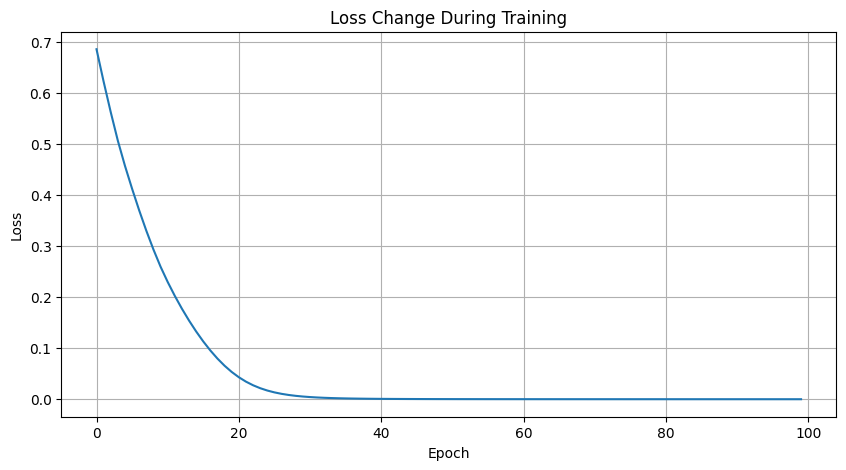

In [11]:
# 손실 곡선 그리기
plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.title('Loss Change During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

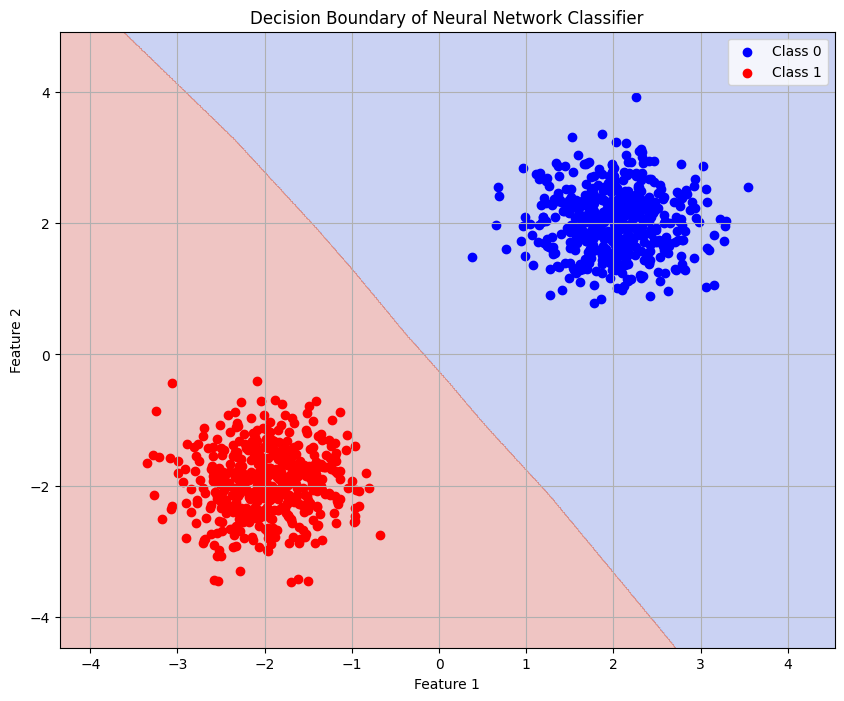

In [13]:
# 결정 경계 시각화 (Visualize decision boundary)
# 결정 경계란 모델이 클래스를 나누는 경계를 의미합니다.
def plot_decision_boundary(model, X, y):
    # 그리드 생성 (Create a grid)
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    
    # 그리드 포인트에 대한 예측 (Predictions for grid points)
    model.eval()
    with torch.no_grad():
        grid = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()]).to(device)
        Z = model(grid).squeeze().cpu().numpy()
        Z = (Z > 0.5).astype(int)
    
    # 결정 경계 표시 (Display decision boundary)
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
    
    # 데이터 포인트 표시 (Display data points)
    plt.scatter(X[y==0, 0], X[y==0, 1], c='blue', label='Class 0')
    plt.scatter(X[y==1, 0], X[y==1, 1], c='red', label='Class 1')

    plt.title('Decision Boundary of Neural Network Classifier')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_decision_boundary(model, X, y)

In [14]:
# 모델 평가 (Evaluate model)
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor).squeeze()
    test_preds = (test_outputs > 0.5).float()
    test_acc = (test_preds == y_test_tensor).float().mean()
    
print(f'최종 테스트 정확도 (Final Test Accuracy): {test_acc:.4f}')

최종 테스트 정확도 (Final Test Accuracy): 1.0000


## 2. 텍스트 인코딩 (토큰화, 임베딩) (Text Encoding - Tokenization, Embedding)

이번엔 기본적인 DL 과정으로 어떻게 언어가 처리되는지 확인해봅시다.   
정확한 원리 이해가 아닌 어떻게 글자가 숫자로 바뀌는지 과정에 집중해봅시다.

### 토이 텍스트 데이터 생성 (Create Toy Text Data)

감정분석 텍스트 데이터입니다.

In [15]:
# 간단한 텍스트 분류 데이터
texts = [
    "This movie was really enjoyable",
    "I liked this book very much",
    "The food wasn't tasty",
    "The service was bad",
    "This product has good quality",
    "The price is too expensive",
    "This place was beautiful",
    "The weather wasn't good",
    "The staff was friendly",
    "The waiting time was too long",
]

# 라벨 생성 (긍정: 1, 부정: 0)
labels = [1, 1, 0, 0, 1, 0, 1, 0, 1, 0]

# 데이터 출력
for text, label in zip(texts, labels):
    sentiment = "긍정(Positive)" if label == 1 else "부정(Negative)"
    print(f"텍스트 (Text): {text} | 감정 (Sentiment): {sentiment}")

텍스트 (Text): This movie was really enjoyable | 감정 (Sentiment): 긍정(Positive)
텍스트 (Text): I liked this book very much | 감정 (Sentiment): 긍정(Positive)
텍스트 (Text): The food wasn't tasty | 감정 (Sentiment): 부정(Negative)
텍스트 (Text): The service was bad | 감정 (Sentiment): 부정(Negative)
텍스트 (Text): This product has good quality | 감정 (Sentiment): 긍정(Positive)
텍스트 (Text): The price is too expensive | 감정 (Sentiment): 부정(Negative)
텍스트 (Text): This place was beautiful | 감정 (Sentiment): 긍정(Positive)
텍스트 (Text): The weather wasn't good | 감정 (Sentiment): 부정(Negative)
텍스트 (Text): The staff was friendly | 감정 (Sentiment): 긍정(Positive)
텍스트 (Text): The waiting time was too long | 감정 (Sentiment): 부정(Negative)


### 토큰화 (Tokenization)

In [18]:
def tokenize(text):
    """
    간단한 공백 기반 토큰화 (Simple space-based tokenization)
    원래는 더 자세한 방법으로 토큰화를 수행해야 합니다.
    그러나 이 실습에서는 간단하게 공백을 기준으로 토큰화합니다.
    """
    # 소문자로 변환 (Convert to lowercase)
    text = text.lower()
    # 기본 전처리 (Basic preprocessing)
    for char in '.,!?':
        text = text.replace(char, ' ' + char + ' ')
    # 토큰 분리 (Split tokens)
    tokens = text.split()
    return tokens

tokenized_texts = [tokenize(text) for text in texts]

# 토큰화 결과 출력 (Print tokenization results)
for i, tokens in enumerate(tokenized_texts[:3]):  # 처음 3개만 출력 (Print first 3 only)
    print(f"원본 (Original): {texts[i]}")
    print(f"토큰화 (Tokenized): {tokens}")
    print("-" * 50)

원본 (Original): This movie was really enjoyable
토큰화 (Tokenized): ['this', 'movie', 'was', 'really', 'enjoyable']
--------------------------------------------------
원본 (Original): I liked this book very much
토큰화 (Tokenized): ['i', 'liked', 'this', 'book', 'very', 'much']
--------------------------------------------------
원본 (Original): The food wasn't tasty
토큰화 (Tokenized): ['the', 'food', "wasn't", 'tasty']
--------------------------------------------------


In [19]:
# 어휘 사전 구축 (Build vocabulary)
def build_vocab(tokenized_texts):
    """
    토큰화된 텍스트에서 어휘 사전 생성 (Create vocabulary from tokenized texts)
    어휘 사전이란, 텍스트 데이터에 등장하는 모든 고유 토큰들을 모아놓은 것입니다.
    이 과정을 수행하는 이유는 모델이 텍스트 데이터를 다루기 위해서는 텍스트를 숫자로 변환해야 하는데,
    이때 토큰을 숫자로 변환하기 위한 사전이 필요하기 때문입니다.
    예를 들어 apple과 banana라는 단어가 있을 때, 
    이를 숫자로 변환하기 위해서는 규칙을 정해야 하는데,
    이 규칙이 바로 어휘 사전입니다.   
    간단하게는 'apple'이라는 단어를 1로 변환하고, 'banana'라는 단어를 2로 변환하는 식입니다.
    아래 코드의 원리는 다음과 같습니다.
    1. 모든 토큰을 수집합니다.
    2. 각 토큰에 고유한 인덱스를 부여합니다.
    3. 패딩을 위한 0번 인덱스를 추가합니다.
    4. 알 수 없는 토큰을 위한 인덱스를 추가합니다.
    5. 역 매핑을 위한 사전을 추가합니다.
    """
    # 모든 고유 토큰 수집 (Collect all unique tokens)
    vocab = set()
    for tokens in tokenized_texts:
        vocab.update(tokens)
    
    # 사전 생성 (Create dictionary)
    word_to_idx = {word: idx+1 for idx, word in enumerate(sorted(vocab))}
    # 패딩을 위한 0 추가 (Add 0 for padding)
    word_to_idx['<PAD>'] = 0
    # 알 수 없는 토큰을 위한 인덱스 추가 (Add index for unknown tokens)
    word_to_idx['<UNK>'] = len(word_to_idx)
    
    # 역 매핑 사전 생성 (Create reverse mapping)
    idx_to_word = {idx: word for word, idx in word_to_idx.items()}
    
    return word_to_idx, idx_to_word

# 어휘 사전 생성 (Create vocabulary)
word_to_idx, idx_to_word = build_vocab(tokenized_texts)

print(f"어휘 크기 (Vocabulary size): {len(word_to_idx)}")
print(f"어휘 사전 샘플 (Vocabulary sample): {dict(list(word_to_idx.items())[:10])}")

어휘 크기 (Vocabulary size): 34
어휘 사전 샘플 (Vocabulary sample): {'bad': 1, 'beautiful': 2, 'book': 3, 'enjoyable': 4, 'expensive': 5, 'food': 6, 'friendly': 7, 'good': 8, 'has': 9, 'i': 10}


In [21]:
# 텍스트를 인덱스로 변환 (Convert text to indices)
def text_to_indices(tokenized_text, word_to_idx, max_len=10):
    """
    토큰화된 텍스트를 인덱스 리스트로 변환 (Convert tokenized text to list of indices)
    위에서 토큰화 및 사전 생성을 진행했기에, 이번엔 그 사전을 이용하여 토큰을 숫자로 바꿔줍시다.
    만약, 토큰이 어휘사전에 있으면 인덱스를 반환하고 아니면, UNK 토큰으로 바꾼 후 인덱스로 바꿔줍니다. 
    """
    indices = []
    
    # 각 토큰을 인덱스로 변환 (Convert each token to index)
    for token in tokenized_text[:max_len]:
        if token in word_to_idx:
            indices.append(word_to_idx[token])
        else:
            indices.append(word_to_idx['<UNK>'])
    
    # 패딩 추가 (Add padding)
    while len(indices) < max_len:
        indices.append(word_to_idx['<PAD>'])
    
    return indices

# 모든 텍스트를 인덱스로 변환 (Convert all texts to indices)
max_len = 10  # 최대 시퀀스 길이 (Maximum sequence length)
indices_list = [text_to_indices(tokens, word_to_idx, max_len) for tokens in tokenized_texts]

# 결과 출력 (Print results)
for i in range(3):  # 처음 3개만 출력 (Print first 3 only)
    print(f"원본 (Original): {texts[i]}")
    print(f"토큰화 (Tokenized): {tokenized_texts[i]}")
    print(f"인덱스 (Indices): {indices_list[i]}")
    print("-" * 50)

원본 (Original): This movie was really enjoyable
토큰화 (Tokenized): ['this', 'movie', 'was', 'really', 'enjoyable']
인덱스 (Indices): [25, 14, 30, 20, 4, 0, 0, 0, 0, 0]
--------------------------------------------------
원본 (Original): I liked this book very much
토큰화 (Tokenized): ['i', 'liked', 'this', 'book', 'very', 'much']
인덱스 (Indices): [10, 12, 25, 3, 28, 15, 0, 0, 0, 0]
--------------------------------------------------
원본 (Original): The food wasn't tasty
토큰화 (Tokenized): ['the', 'food', "wasn't", 'tasty']
인덱스 (Indices): [24, 6, 31, 23, 0, 0, 0, 0, 0, 0]
--------------------------------------------------


In [23]:
# 위에서 토크나이징을 하고, 인덱스로 바꾸었으므로, 이번엔 신경망이 처리할 수 있는 텐서로 바꾸어줍니다.
# 인덱스를 PyTorch 텐서로 변환 (Convert indices to PyTorch tensor)
X_tensor = torch.LongTensor(indices_list).to(device)
y_tensor = torch.FloatTensor(labels).to(device)

print(f"X 텐서 모양 (X tensor shape): {X_tensor.shape}")
print(f"y 텐서 모양 (y tensor shape): {y_tensor.shape}")

X 텐서 모양 (X tensor shape): torch.Size([10, 10])
y 텐서 모양 (y tensor shape): torch.Size([10])


앞서 우리는 데이터를 토큰화하고 숫자로 변환하는 과정을 살펴봤습니다. 이제 이 숫자들이 어떻게 의미 있는 정보로 처리되는지 더 자세히 알아보겠습니다.

**텍스트 처리 과정 리캡**

텍스트가 모델에 입력되기까지의 과정을 다시 한번 정리해보면:

토큰화(Tokenization): 텍스트를 의미 있는 단위(토큰)로 분리합니다. 위 코드에서는 간단히 공백을 기준으로 분리했습니다.
어휘 사전(Vocabulary) 구축: 모든 고유한 토큰을 모아 각각에 고유한 숫자(인덱스)를 부여합니다.
인덱스 변환: 텍스트를 해당 인덱스의 시퀀스로 변환합니다.
패딩(Padding): 모든 시퀀스의 길이를 동일하게 맞춥니다.

이 과정을 통해 자연어를 컴퓨터가 이해할 수 있는 "숫자"로 변환했습니다.   
이제는 컴퓨터가 그 숫자를 어떻게 처리하는지 봐봅시다.

### 임베딩(Embedding)이란?   

임베딩은 단어나 토큰을 고차원 벡터 공간에 매핑하는 기술입니다.   
즉, 단순히 숫자로 변환하는 것이 아니라, 각 단어의 '의미'를 담은 벡터로 표현합니다.      
비슷한 단어들은 비슷한 위치에 존재하게 되고, 그 반대의 경우엔 다른 위치에 존재하게 됩니다.
이미지를 참고해주세요!
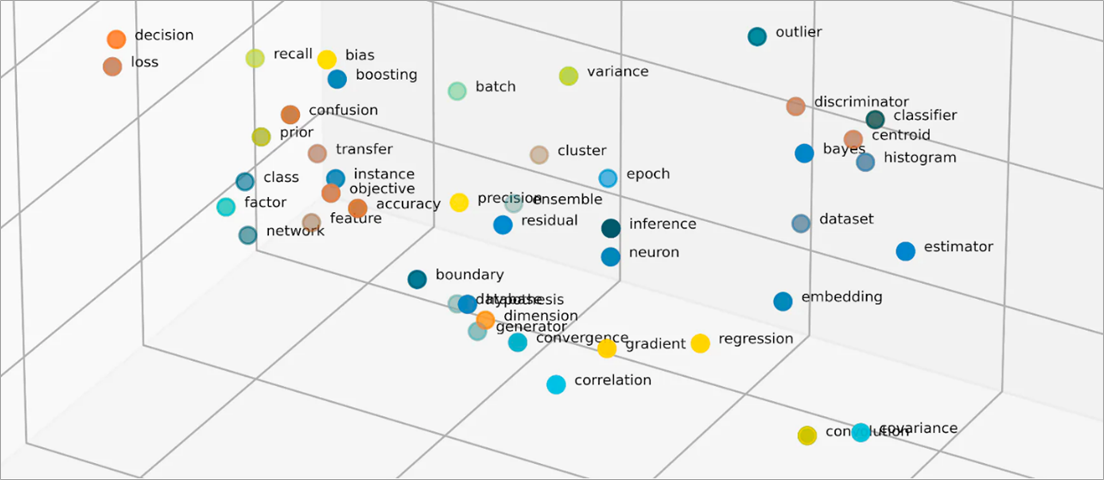

예를 들어, "king"과 "queen", "man"과 "woman"은 서로 유사한 관계를 갖게 되며, 이는 벡터 연산으로도 표현될 수 있습니다:  
`king - man + woman ≈ queen`

앞으로 마주칠 모든 자연어처리 기술은 근본적으로 이 임베딩을 어떻게 잘 생성하는지가 목표라고 볼 수 있습니다.

In [25]:
class TextClassifier(nn.Module):
    """
    임베딩 레이어를 사용한 텍스트 분류 모델 (Text classification model using embedding layer)
    """
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        """
        모델 초기화 (Initialize model)
        """
        super(TextClassifier, self).__init__()
        
        # 임베딩 레이어 (Embedding layer)
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        
        # LSTM 레이어 (LSTM layer)
        self.lstm = nn.LSTM(embedding_dim, 
                          hidden_dim, 
                          num_layers=1, 
                          batch_first=True, 
                          bidirectional=True)
        
        # 드롭아웃 (Dropout)
        self.dropout = nn.Dropout(0.3)
        
        # 출력 레이어 (Output layer)
        # 양방향 LSTM이므로 hidden_dim * 2 (Bidirectional LSTM, so hidden_dim * 2)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        
        # 활성화 함수 (Activation function)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, text):
        """
        순전파 (Forward pass)
        """
        # 텍스트를 임베딩으로 변환 (Convert text to embeddings)
        # text: [batch_size, seq_len]
        embedded = self.embedding(text)
        # embedded: [batch_size, seq_len, embedding_dim]
        
        # LSTM 레이어에 통과 (Pass through LSTM layer)
        output, (hidden, cell) = self.lstm(embedded)
        # output: [batch_size, seq_len, hidden_dim * 2]
        # hidden: [2, batch_size, hidden_dim]
        
        # 양방향 LSTM의 마지막 은닉 상태 연결 (Concatenate last hidden states of bidirectional LSTM)
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        # hidden: [batch_size, hidden_dim * 2]
        
        # 드롭아웃 적용 (Apply dropout)
        hidden = self.dropout(hidden)
        
        # 출력층에 통과 (Pass through output layer)
        output = self.fc(hidden)
        # output: [batch_size, output_dim]
        
        # 시그모이드 활성화 (Sigmoid activation)
        return self.sigmoid(output)

# 모델 인스턴스 생성 (Create model instance)
vocab_size = len(word_to_idx)
embedding_dim = 50
hidden_dim = 32
output_dim = 1

model = TextClassifier(vocab_size, embedding_dim, hidden_dim, output_dim).to(device)
print(model)

# 손실 함수와 옵티마이저 정의 (Define loss function and optimizer)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

TextClassifier(
  (embedding): Embedding(34, 50, padding_idx=0)
  (lstm): LSTM(50, 32, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


### TextClassifier 클래스 설명

이제 주어진 코드의 TextClassifier 클래스를 살펴보겠습니다.

**1. 모델 구조**

```python
class TextClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(TextClassifier, self).__init__()
        
        # 임베딩 레이어
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        
        # LSTM 레이어
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=1, 
                          batch_first=True, bidirectional=True)
        
        # 드롭아웃
        self.dropout = nn.Dropout(0.3)
        
        # 출력 레이어
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        
        # 활성화 함수
        self.sigmoid = nn.Sigmoid()
```

이 모델은 먼저, 임베딩 레이어로 토큰 인덱스를 의미 있는 벡터로 변환합니다.      
그 후, LSTM 레이어를 통해 시퀀스 정보를 처리해줍니다. (모델 구조에 대한 설명은 생략)   
다음으로 과적합을 방지하기 위해 드롭아웃을 적용하고, 출력 레이어를 통해 예측을 위해 구조를 output_dim으로 바꾸어줍니다.
그 후 시그모이드 활성화함수로 출력을 0~1 사이 확률로 변환해줍니다. 

**맨 처음 이 코드의 목적이 감정분석이었다는 것을 생각해봅시다! 즉, 이진분류이므로 이렇게 연산합니다.**

**2. 임베딩 레이어 깊게 이해하기**

위에서 알아본 임베딩에 대해 실제로는 어떻게 구현되는지 봅시다.

```python
self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
```

- **vocab_size**: 어휘 사전의 크기(고유 토큰 수)입니다.
- **embedding_dim**: 각 토큰이 변환될 벡터의 차원입니다.
- **padding_idx=0**: 패딩 토큰(인덱스 0)은 항상 0 벡터로 매핑됩니다.

실제로 각 단어는 임의의 값으로 초기화된 embedding_dim 차원의 벡터로 변환됩니다. 이 벡터는 학습 과정에서 점차 의미 있는 값으로 조정됩니다.   
즉, 처음에는 랜덤한 값으로 각단어에 대한 벡터표현이 만들어지고 학습과정에서 의미있는 값으로 변하게 됩니다.   

**3. 순전파(Forward Pass) 과정**

```python
def forward(self, text):
    # 텍스트를 임베딩으로 변환
    embedded = self.embedding(text)
    # embedded: [batch_size, seq_len, embedding_dim]
    
    # LSTM 레이어에 통과
    output, (hidden, cell) = self.lstm(embedded)
    # hidden: [2, batch_size, hidden_dim]
    
    # 양방향 LSTM의 마지막 은닉 상태 연결
    hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
    # hidden: [batch_size, hidden_dim * 2]
    
    # 드롭아웃 적용
    hidden = self.dropout(hidden)
    
    # 출력층에 통과
    output = self.fc(hidden)
    
    # 시그모이드 활성화
    return self.sigmoid(output)
```

순전파 과정을 단계별로 살펴보면:

1. **임베딩 변환** 
   - 입력: `[배치 크기, 시퀀스 길이]` 형태의 토큰 인덱스
   - 출력: `[배치 크기, 시퀀스 길이, 임베딩 차원]` 형태의 임베딩 벡터

2. **LSTM 처리**
   - 임베딩된 시퀀스를 양방향 LSTM에 통과시킵니다.
   - LSTM은 순차적 정보를 처리하는 특별한 형태의 RNN입니다.
   - 양방향(bidirectional)이므로 시퀀스를 앞에서 뒤로, 뒤에서 앞으로 두 번 처리합니다.

3. **은닉 상태 결합**
   - 양방향 LSTM의 최종 은닉 상태를 결합합니다.
   - `hidden[-2,:,:]`는 정방향, `hidden[-1,:,:]`는 역방향 처리의 최종 상태입니다.

4. **드롭아웃 적용**
   - 일부 뉴런을 무작위로 비활성화하여 과적합을 방지합니다.

5. **출력층 및 활성화**
   - 완전 연결 레이어를 통과시키고 시그모이드 함수로 0~1 사이 확률값으로 변환합니다.

**예시로 이해하기**

간단한 문장 "The movie was good"이 모델을 통과하는 과정을 상상해봅시다.

1. 토큰화: `["the", "movie", "was", "good"]`
2. 인덱스 변환: `[5, 10, 7, 3]` (임의의 인덱스)
3. 임베딩 변환: 각 인덱스가 50차원 벡터로 변환 → `[4 × 50]` 행렬
4. LSTM 처리: 이 임베딩 시퀀스가 LSTM을 통과
5. 최종 은닉 상태 결합: 양방향 처리의 결과 결합 → `[1 × 64]` 벡터 (hidden_dim=32 × 2)
6. 드롭아웃 및 출력층: 최종 확률값(예: 0.92) 출력 (이 확률값은 문장이 긍정적(1)인지 부정적(0)인지를 나타냅니다. 0.5보다 크므로 긍정이라 판단할 수 있죠.)

**추가**
모델이 학습을 마치면 임베딩 레이어의 가중치가 의미 있는 단어 벡터가 됩니다!

### 텍스트 모델 학습 (Train Text Model)

In [26]:
# 학습/테스트 데이터 분할 (Split training/test data)
def train_test_split(X, y, train_ratio=0.8):
    """
    데이터를 학습/테스트로 분할 (Split data into train/test)
    """
    n_samples = len(X)
    train_size = int(n_samples * train_ratio)
    
    # 데이터 인덱스 섞기 (Shuffle data indices)
    indices = torch.randperm(n_samples)
    
    train_indices = indices[:train_size]
    test_indices = indices[train_size:]
    
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    return X_train, y_train, X_test, y_test

# 데이터 분할 (Split data)
X_train, y_train, X_test, y_test = train_test_split(X_tensor, y_tensor)

print(f"학습 데이터 크기 (Training data size): {X_train.shape}")
print(f"테스트 데이터 크기 (Test data size): {X_test.shape}")

학습 데이터 크기 (Training data size): torch.Size([8, 10])
테스트 데이터 크기 (Test data size): torch.Size([2, 10])


In [27]:
# 학습 루프 (Training loop)
num_epochs = 100
losses = []

for epoch in range(num_epochs):
    # 모델을 학습 모드로 설정 (Set model to training mode)
    model.train()
    
    # 순전파 (Forward pass)
    outputs = model(X_train).squeeze()
    
    # 손실 계산 (Calculate loss)
    loss = criterion(outputs, y_train)
    
    # 역전파 및 최적화 (Backpropagation and optimization)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # 손실 기록 (Record loss)
    losses.append(loss.item())
    
    # 학습 과정 출력 (Print training progress)
    if (epoch + 1) % 10 == 0:
        # 테스트 데이터에 대한 성능 평가 (Evaluate on test data)
        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test).squeeze()
            test_loss = criterion(test_outputs, y_test)
            
            # 예측값 계산 (Calculate predictions)
            train_preds = (outputs > 0.5).float()
            test_preds = (test_outputs > 0.5).float()
            
            # 정확도 계산 (Calculate accuracy)
            train_acc = (train_preds == y_train).float().mean()
            test_acc = (test_preds == y_test).float().mean()
        
        print(f'에포크 (Epoch) [{epoch+1}/{num_epochs}], '
              f'손실 (Loss): {loss.item():.4f}, '
              f'학습 정확도 (Train Acc): {train_acc:.4f}, '
              f'테스트 정확도 (Test Acc): {test_acc:.4f}')

에포크 (Epoch) [10/100], 손실 (Loss): 0.0371, 학습 정확도 (Train Acc): 1.0000, 테스트 정확도 (Test Acc): 1.0000
에포크 (Epoch) [20/100], 손실 (Loss): 0.0007, 학습 정확도 (Train Acc): 1.0000, 테스트 정확도 (Test Acc): 1.0000
에포크 (Epoch) [30/100], 손실 (Loss): 0.0002, 학습 정확도 (Train Acc): 1.0000, 테스트 정확도 (Test Acc): 1.0000
에포크 (Epoch) [40/100], 손실 (Loss): 0.0001, 학습 정확도 (Train Acc): 1.0000, 테스트 정확도 (Test Acc): 1.0000
에포크 (Epoch) [50/100], 손실 (Loss): 0.0001, 학습 정확도 (Train Acc): 1.0000, 테스트 정확도 (Test Acc): 1.0000
에포크 (Epoch) [60/100], 손실 (Loss): 0.0001, 학습 정확도 (Train Acc): 1.0000, 테스트 정확도 (Test Acc): 1.0000
에포크 (Epoch) [70/100], 손실 (Loss): 0.0001, 학습 정확도 (Train Acc): 1.0000, 테스트 정확도 (Test Acc): 1.0000
에포크 (Epoch) [80/100], 손실 (Loss): 0.0000, 학습 정확도 (Train Acc): 1.0000, 테스트 정확도 (Test Acc): 1.0000
에포크 (Epoch) [90/100], 손실 (Loss): 0.0001, 학습 정확도 (Train Acc): 1.0000, 테스트 정확도 (Test Acc): 1.0000
에포크 (Epoch) [100/100], 손실 (Loss): 0.0001, 학습 정확도 (Train Acc): 1.0000, 테스트 정확도 (Test Acc): 1.0000


### 모델 평가 및 임베딩 시각화 (Evaluate Model and Visualize Embeddings)

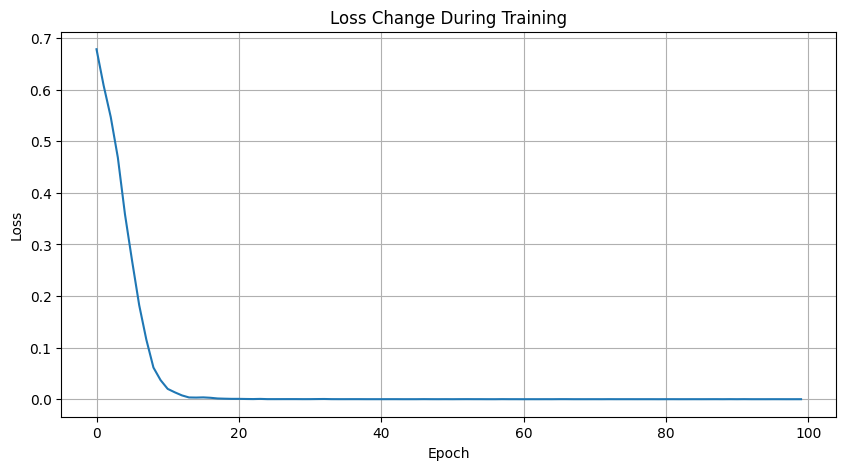

In [28]:
# 손실 곡선 그리기 (Plot loss curve)
plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.title('Loss Change During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [29]:
# 임베딩 가중치 추출 (Extract embedding weights)
embedding_weights = model.embedding.weight.cpu().detach().numpy()
print(f"임베딩 가중치 모양 (Embedding weights shape): {embedding_weights.shape}")

임베딩 가중치 모양 (Embedding weights shape): (34, 50)


In [30]:
# 임베딩 시각화를 위한 차원 축소 (Dimensionality reduction for embedding visualization)
from sklearn.decomposition import PCA

# PCA를 사용한 차원 축소 (Dimensionality reduction using PCA)
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embedding_weights)

In [31]:
# 패딩과 UNK 토큰 제외 (Exclude padding and UNK tokens)
valid_embeddings = embeddings_2d[1:-1]  # 패딩과 UNK 제외 (Exclude padding and UNK)
valid_words = list(word_to_idx.keys())[1:-1]  # 패딩과 UNK 제외 (Exclude padding and UNK)

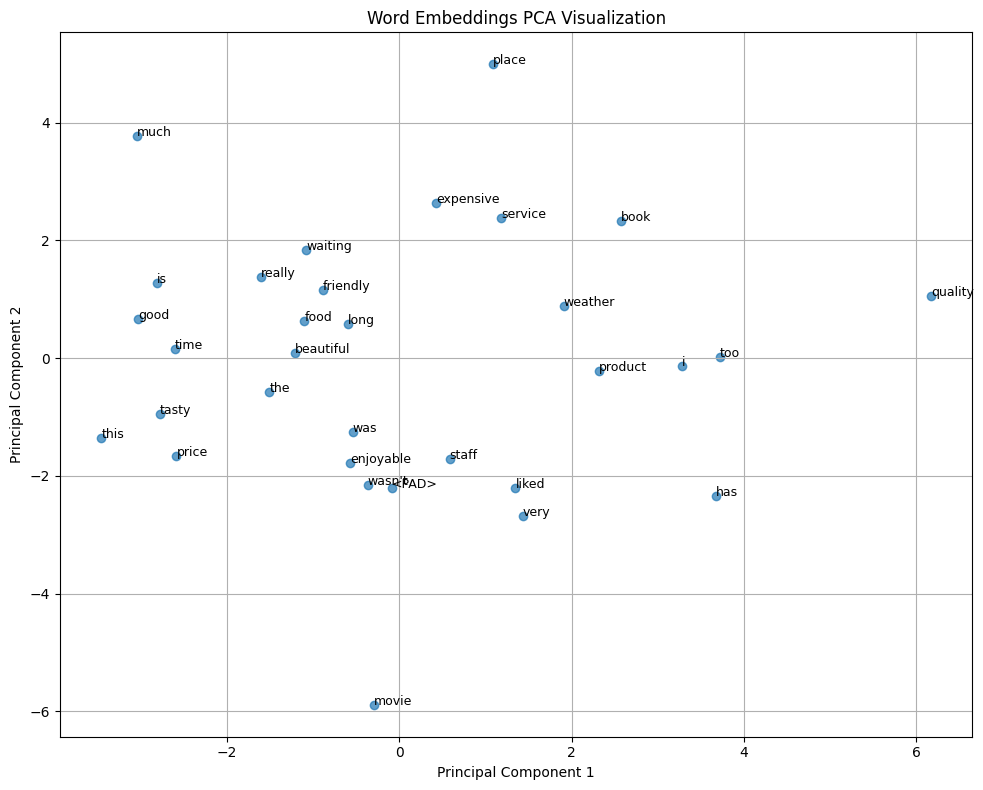

In [33]:
plt.figure(figsize=(10, 8))

# 임베딩 포인트 그리기
plt.scatter(valid_embeddings[:, 0], valid_embeddings[:, 1], alpha=0.7)

# 주요 단어 레이블 추가 (모든 단어를 표시하면 복잡해질 수 있어 일부만 표시)
for i, word in enumerate(valid_words):
    plt.annotate(word, (valid_embeddings[i, 0], valid_embeddings[i, 1]), fontsize=9)

plt.title('Word Embeddings PCA Visualization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.tight_layout()
plt.show()

### 새로운 텍스트 분류 (Classify New Text)

In [34]:
# 새로운 텍스트 분류 함수 (Function to classify new text)
def classify_text(text, model, word_to_idx, max_len=10):
    """
    새로운 텍스트 분류 (Classify new text)
    """
    # 토큰화 (Tokenize)
    tokens = tokenize(text)
    
    # 인덱스 변환 (Convert to indices)
    indices = text_to_indices(tokens, word_to_idx, max_len)
    
    # 텐서 변환 (Convert to tensor)
    tensor = torch.LongTensor([indices]).to(device)
    
    # 예측 (Predict)
    model.eval()
    with torch.no_grad():
        output = model(tensor).item()
    
    # 결과 해석 (Interpret result)
    probability = output
    prediction = 1 if probability > 0.5 else 0
    sentiment = "긍정(Positive)" if prediction == 1 else "부정(Negative)"
    
    return sentiment, probability

In [ ]:
new_texts = [
    "This product is very good",
    "The service was terrible",
    "It wasn't as bad as I thought",
    "Overall, I am satisfied"
]

for text in new_texts:
    sentiment, probability = classify_text(text, model, word_to_idx)
    print(f"텍스트 (Text): {text}")
    print(f"감정 (Sentiment): {sentiment}")
    print(f"확률 (Probability): {probability:.4f}")
    print("-" * 50)

텍스트 (Text): This product is very good
감정 (Sentiment): 긍정(Positive)
확률 (Probability): 0.9997
--------------------------------------------------
텍스트 (Text): The service was terrible
감정 (Sentiment): 부정(Negative)
확률 (Probability): 0.0010
--------------------------------------------------
텍스트 (Text): It wasn't as bad as I thought
감정 (Sentiment): 부정(Negative)
확률 (Probability): 0.0011
--------------------------------------------------
텍스트 (Text): Overall, I am satisfied
감정 (Sentiment): 긍정(Positive)
확률 (Probability): 0.9273
--------------------------------------------------
